In [6]:
!apt-get -y install tesseract-ocr
!pip install opencv-python pytesseract Pillow regex spacy
!python -m spacy download en_core_web_sm


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import cv2
import pytesseract
import re
import spacy
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

nlp = spacy.load("en_core_web_sm")


In [15]:
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))


Saving page_30.jpg to page_30.jpg
Uploaded files: ['page_30.jpg']


In [9]:
def preprocess_image(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)
    return img, th


In [10]:
def extract_text(img):
    return pytesseract.image_to_string(img, lang="eng")

def clean_text(t):
    t = t.replace("\n", " ")
    return re.sub(r"\s+", " ", t).strip()


In [11]:
def detect_pii(text):
    res = {}

    phones = re.findall(r"\b(?:\+91[- ]?)?\d{10}\b", text)
    emails = re.findall(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", text)

    doc = nlp(text)
    names = [e.text for e in doc.ents if e.label_ == "PERSON"]
    dates = [e.text for e in doc.ents if e.label_ == "DATE"]

    res["phones"] = phones
    res["emails"] = emails
    res["names"] = names
    res["dates"] = dates

    return res


In [12]:
def redact_image(img, pii_words):
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    for i, w in enumerate(data['text']):
        if w in pii_words:
            x = data['left'][i]
            y = data['top'][i]
            w_b = data['width'][i]
            h_b = data['height'][i]
            cv2.rectangle(img, (x, y), (x+w_b, y+h_b), (0,0,0), -1)
    return img


In [13]:
def run_pipeline(image_path):
    org, prep = preprocess_image(image_path)
    raw = extract_text(prep)
    text = clean_text(raw)
    pii = detect_pii(text)

    pw = []
    for v in pii.values():
        for x in v:
            pw.extend(x.split(" "))

    red = redact_image(org.copy(), pw)

    print("Extracted Text:\n", text)
    print("\nPII:\n", pii)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(red, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    cv2.imwrite(f"redacted_{image_path}", red)
    with open("extracted_text.txt", "w") as f:
        f.write(text)

    return text, pii


Extracted Text:
 fee MY IMS KSUIQDITORM NO.ERD, Cason t. cTreatmentAdvised._ :

PII:
 {'phones': [], 'emails': [], 'names': ['Cason t.'], 'dates': []}


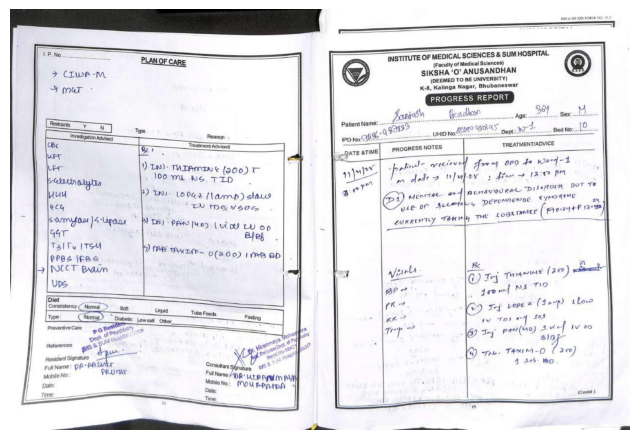

In [16]:
text, pii = run_pipeline("page_30.jpg")
